# Project Title: COVID-19 Dataset Exploration

Project Description: https://github.com/owid/covid-19-data

# Import Modules

In [1]:
import os
import pyspark
import warnings
import pandas as pd
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlopen
from pyspark.sql import SparkSession

# Options and Settings

In [2]:
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load Image

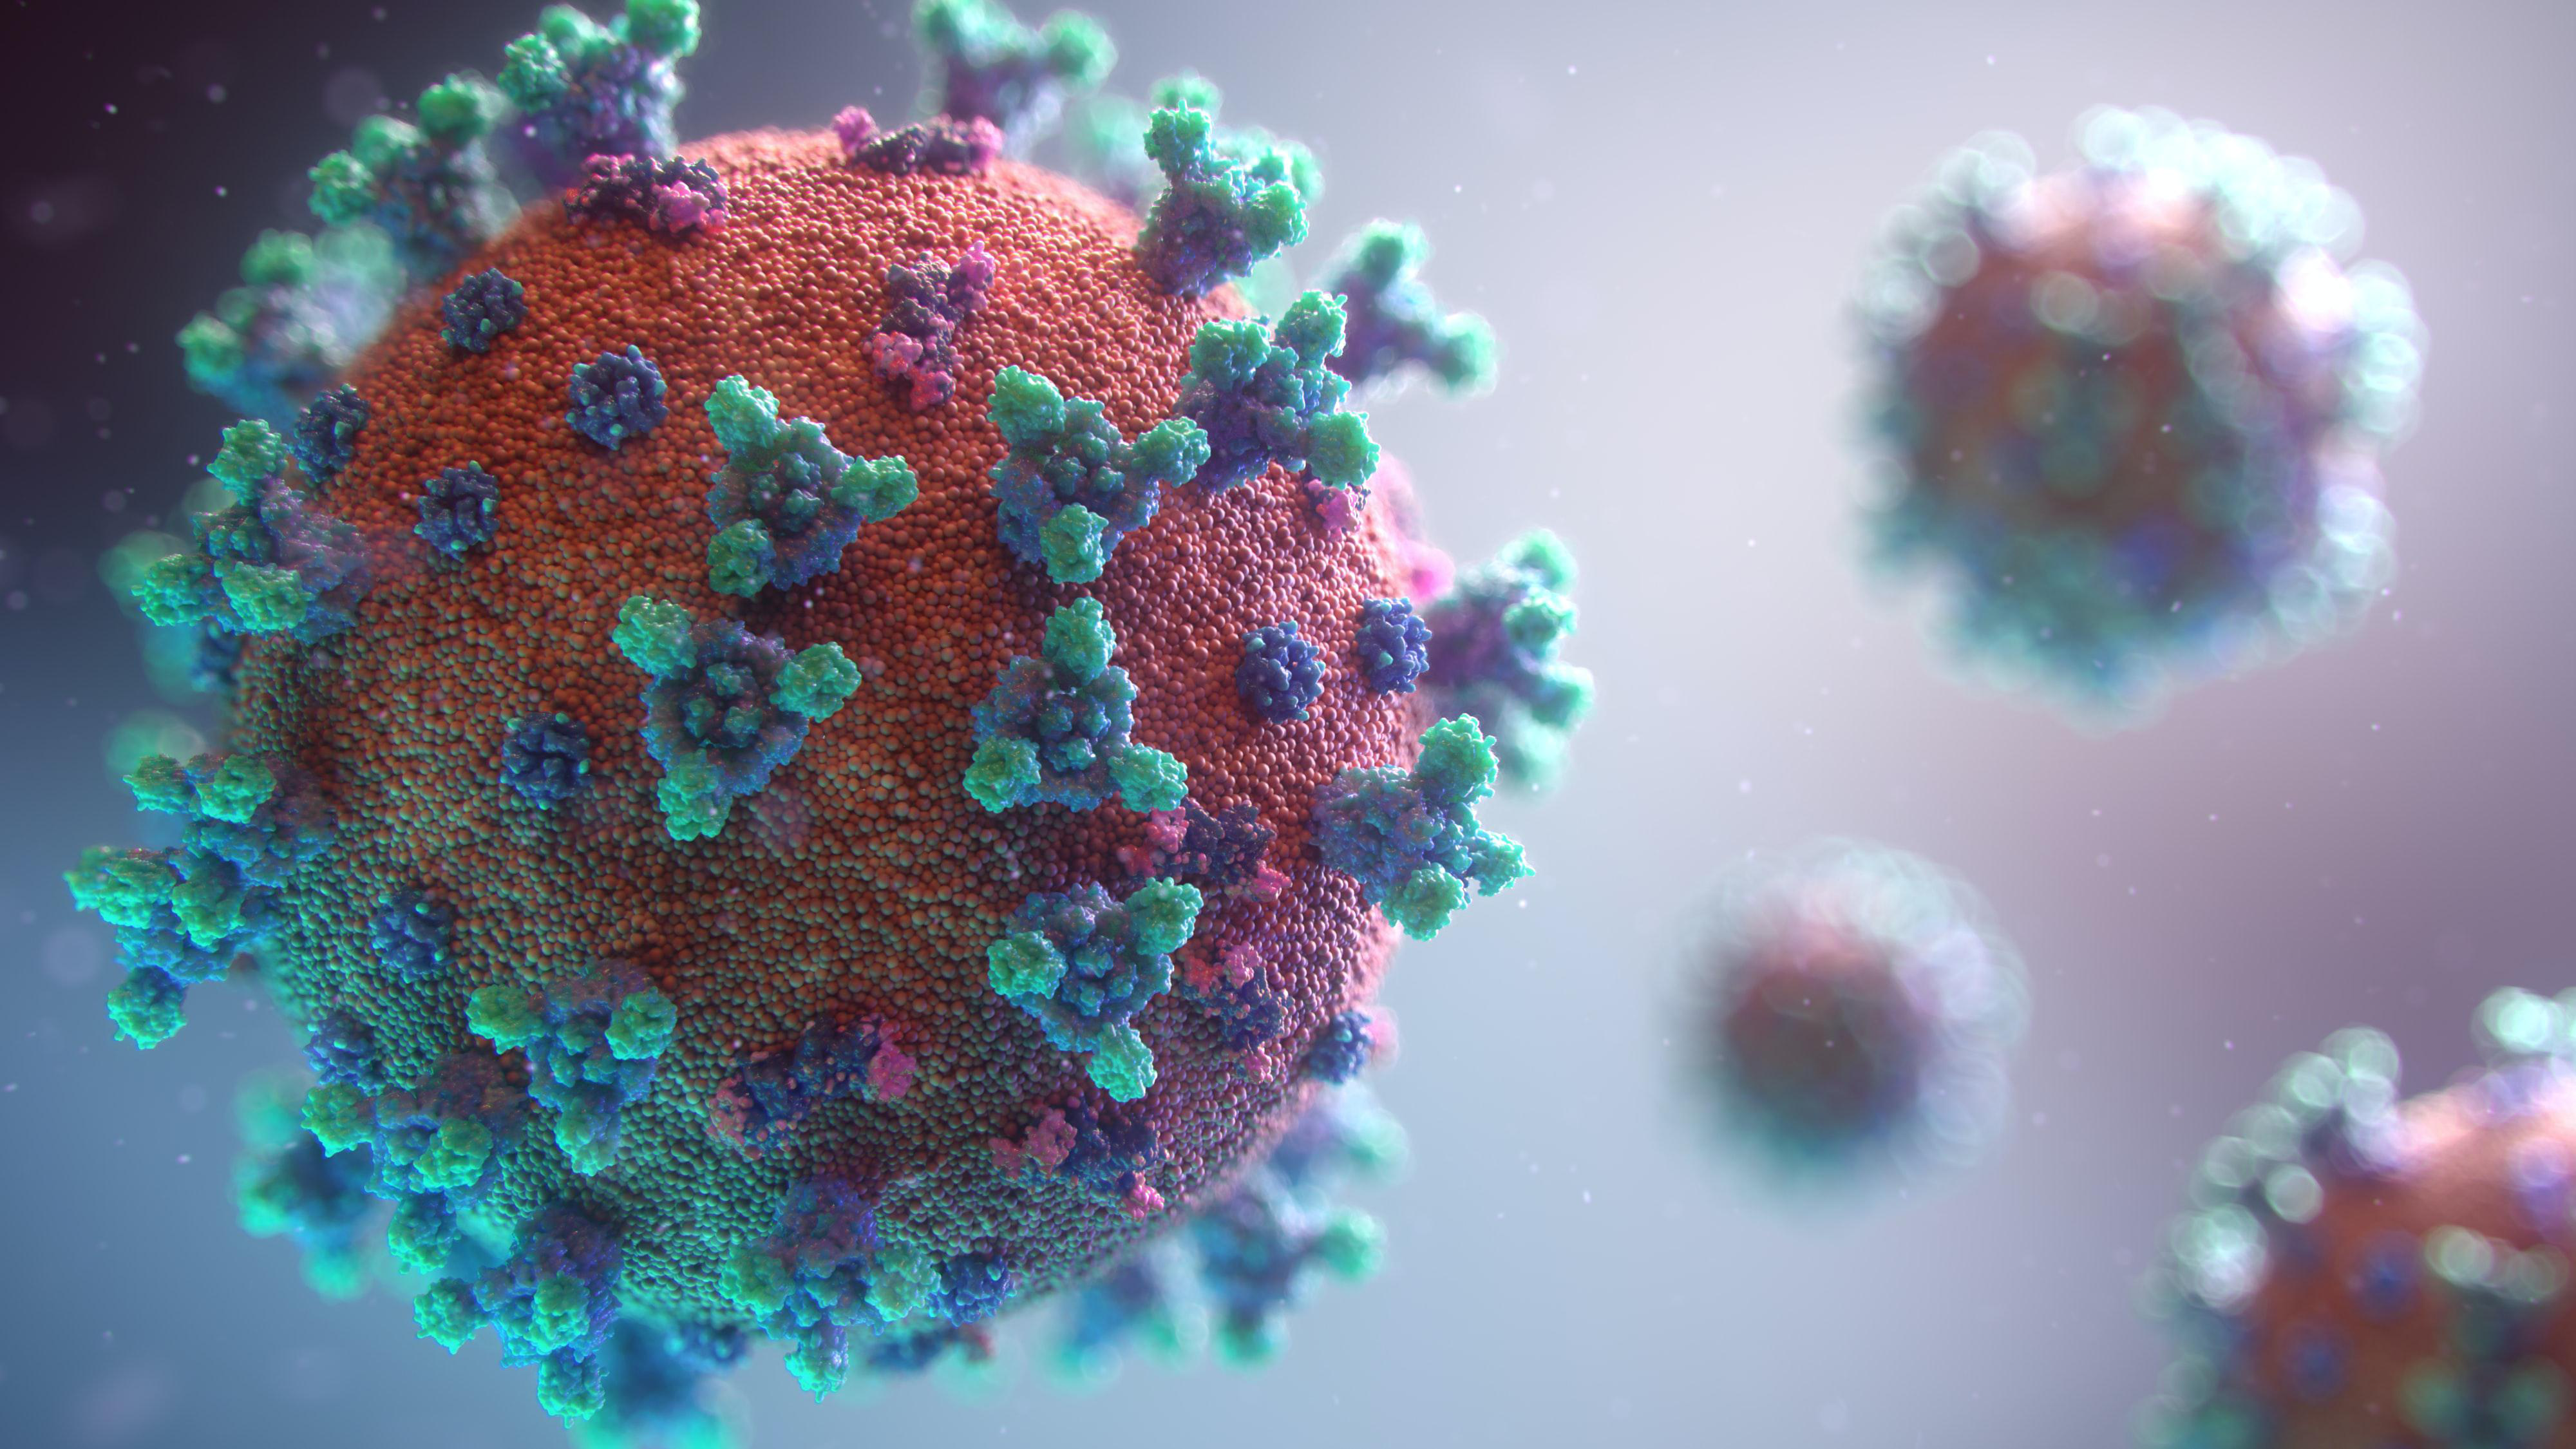

In [3]:
image_url = 'https://www.unbonn.org/sites/default/files/styles/feed_news_crop_image_style/public/news-images/fusion-medical-animation-rnr8D3FNUNY-unsplash_0.jpg?itok=FH1r47i1'
Image.open(urlopen(image_url))

# Create Spark Session

In [4]:
spark = SparkSession.builder.master('local').appName('Covid-19').getOrCreate()
print(f'The PySpark {spark.version} version is running....')

The PySpark 3.3.2 version is running....


# Fetch Data

In [5]:
df_pd = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [6]:
df_pd

iso_code continent     location        date  total_cases  new_cases  \
0           AFG      Asia  Afghanistan  2020-01-03          NaN        0.0   
1           AFG      Asia  Afghanistan  2020-01-04          NaN        0.0   
2           AFG      Asia  Afghanistan  2020-01-05          NaN        0.0   
3           AFG      Asia  Afghanistan  2020-01-06          NaN        0.0   
4           AFG      Asia  Afghanistan  2020-01-07          NaN        0.0   
...         ...       ...          ...         ...          ...        ...   
316654      ZWE    Africa     Zimbabwe  2023-06-03     265139.0       32.0   
316655      ZWE    Africa     Zimbabwe  2023-06-04     265139.0        0.0   
316656      ZWE    Africa     Zimbabwe  2023-06-05     265139.0        0.0   
316657      ZWE    Africa     Zimbabwe  2023-06-06     265139.0        0.0   
316658      ZWE    Africa     Zimbabwe  2023-06-07     265139.0        0.0   

        new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                      NaN           NaN         0.0                  NaN   
1                      NaN           NaN         0.0                  NaN   
2                      NaN           NaN         0.0                  NaN   
3                      NaN           NaN         0.0                  NaN   
4                      NaN           NaN         0.0                  NaN   
...                    ...           ...         ...                  ...   
316654              21.000        5695.0         0.0                0.429   
316655              16.571        5695.0         0.0                0.286   
316656              15.571        5695.0         0.0                0.000   
316657              15.571        5695.0         0.0                0.000   
316658               9.286        5695.0         0.0                0.000   

        ...  male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0       ...           NaN                  37.746                         0.5   
1       ...           NaN                  37.746                         0.5   
2       ...           NaN                  37.746                         0.5   
3       ...           NaN                  37.746                         0.5   
4       ...           NaN                  37.746                         0.5   
...     ...           ...                     ...                         ...   
316654  ...          30.7                  36.791                         1.7   
316655  ...          30.7                  36.791                         1.7   
316656  ...          30.7                  36.791                         1.7   
316657  ...          30.7                  36.791                         1.7   
316658  ...          30.7                  36.791                         1.7   

        life_expectancy  human_development_index  population  \
0                 64.83                    0.511  41128772.0   
1                 64.83                    0.511  41128772.0   
2                 64.83                    0.511  41128772.0   
3                 64.83                    0.511  41128772.0   
4                 64.83                    0.511  41128772.0   
...                 ...                      ...         ...   
316654            61.49                    0.571  16320539.0   
316655            61.49                    0.571  16320539.0   
316656            61.49                    0.571  16320539.0   
316657            61.49                    0.571  16320539.0   
316658            61.49                    0.571  16320539.0   

        excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                        NaN                          NaN   
1                                        NaN                          NaN   
2                                        NaN                          NaN   
3                                        NaN                          NaN   
4                 

# Convert Pandas To Pyspark Dataframe

In [7]:
spark.conf.set('spark.sql.execution.arrow.enabled','true')
df_spark = spark.createDataFrame(df_pd)
df_spark.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million

# Create a global temporal view

In [8]:
df_spark.createOrReplaceGlobalTempView('covid_data')

# Queries

Returns Total Cases and Deaths For Each Continent and Year

In [9]:
query1 = '''

         with
             cases_tbl as (
                            select 
                                  distinct 
                                          cd.continent,
                                          cd.total_cases,
                                          cd.total_deaths,
                                          extract(year from cd.date) as yr,
                                          cd.date
                            from global_temp.covid_data cd
                          ),
             final_tbl as (
                           select 
                                 distinct 
                                         continent,
                                         -- date,
                                         yr,
                                         sum(total_cases) over w as total_cases,
                                         sum(total_deaths) over w as total_deaths   
                           from cases_tbl
                           window w as (partition by continent, yr)
                          )
         
       select distinct * 
       from final_tbl 
       where continent IS NOT NULL

         '''

spark.sql(query1).show()

+-------------+----+---------------+------------+
|    continent|  yr|    total_cases|total_deaths|
+-------------+----+---------------+------------+
|       Africa|2020|   2.92763974E8|   7367266.0|
|       Africa|2021|  2.242424132E9| 5.7117491E7|
|       Africa|2022|  4.490013799E9| 9.2502409E7|
|       Africa|2023|  2.063622004E9|  4.088799E7|
|         Asia|2020|  2.111091632E9| 3.8253884E7|
|         Asia|2021|1.9709385753E10|2.88930832E8|
|         Asia|2022|5.7424288011E10|5.22355315E8|
|         Asia|2023|4.6515792623E10|2.55852979E8|
|       Europe|2020|  1.729433693E9| 6.9313343E7|
|       Europe|2021|1.8398679568E10|4.07560766E8|
|       Europe|2022|7.2069739912E10| 6.8066297E8|
|       Europe|2023|3.9054048002E10|3.23093904E8|
|North America|2020|  2.016361499E9| 7.0671459E7|
|North America|2021| 1.557111709E10|3.39876813E8|
|North America|2022|3.7654187302E10|5.28622592E8|
|North America|2023|1.9401971519E10|2.50218997E8|
|      Oceania|2020|      7141896.0|    160576.0|


Returns New Cases and New Deaths Analysis

In [10]:
query2 = '''
         select 
               distinct 
                        cd.continent,
                        round(avg(cd.new_cases) over w) as avg_new_cases,
                        sum(cd.new_cases) over w as total_new_cases, 
                        round(avg(cd.new_deaths) over w) as avg_new_deaths,
                        sum(cd.new_deaths) over w as total_new_deaths,
                        -- cd.date,
                        extract(year from cd.date) as yr
         from global_temp.covid_data cd
         where cd.continent IS NOT NULL
         window w as (partition by cd.continent, extract(year from cd.date))
         order by continent, yr 

         '''

spark.sql(query2).show()

+-------------+-------------+---------------+--------------+----------------+----+
|    continent|avg_new_cases|total_new_cases|avg_new_deaths|total_new_deaths|  yr|
+-------------+-------------+---------------+--------------+----------------+----+
|       Africa|        132.0|      2747852.0|           3.0|         65057.0|2020|
|       Africa|        341.0|      7103383.0|           8.0|        163826.0|2021|
|       Africa|        151.0|      3149825.0|           1.0|         29630.0|2022|
|       Africa|         10.0|        92105.0|           0.0|           451.0|2023|
|         Asia|       1209.0|    2.0660508E7|          20.0|        337924.0|2020|
|         Asia|       3741.0|    6.4184647E7|          54.0|        921397.0|2021|
|         Asia|      11072.0|   1.89923341E8|          16.0|        273963.0|2022|
|         Asia|       3113.0|    2.3048735E7|          13.0|         99910.0|2023|
|       Europe|       1276.0|     2.368442E7|          32.0|        586535.0|2020|
|   

Returns Total (Reproduction Rate, ICU Patients and Hospital Patients )

In [11]:
query3 = '''
         select 
               distinct 
                       cd.location,
                       round(sum(cd.reproduction_rate) over w) as total_reproduction_rate,
                       round(sum(cd.icu_patients) over w) as total_icu_patients,
                       round(sum(cd.hosp_patients) over w) as total_hospital_patients,
                       -- cd.date,
                       extract(year from cd.date) as yr
         from global_temp.covid_data cd
         where cd.icu_patients IS NOT NULL and cd.hosp_patients IS NOT NULL
         window w as (partition by cd.location)

         '''

spark.sql(query3).show()

+---------+-----------------------+------------------+-----------------------+----+
| location|total_reproduction_rate|total_icu_patients|total_hospital_patients|  yr|
+---------+-----------------------+------------------+-----------------------+----+
|Australia|                 1083.0|           90801.0|              1598022.0|2020|
|Australia|                 1083.0|           90801.0|              1598022.0|2021|
|Australia|                 1083.0|           90801.0|              1598022.0|2022|
|Australia|                 1083.0|           90801.0|              1598022.0|2023|
|  Austria|                 1046.0|          203371.0|              1421016.0|2020|
|  Austria|                 1046.0|          203371.0|              1421016.0|2021|
|  Austria|                 1046.0|          203371.0|              1421016.0|2022|
|  Austria|                 1046.0|          203371.0|              1421016.0|2023|
|  Belgium|                 1159.0|          346657.0|              2053368.

Returns Tests by Continent 

In [12]:
query4 = '''
         select yr, continent, round(avg(new_tests)) as avg_tests, sum(total_tests) as total_tests
         from (
                select 
                      distinct 
                              cd.continent,
                              cd.new_tests,
                              cd.total_tests,
                              year(cd.date) as yr
                from global_temp.covid_data cd
              ) as sub_query
          where continent IS NOT NULL and continent in ('South America', 'Africa')
          group by continent, yr
          order by 1, 2

         '''

spark.sql(query4).show()

+----+-------------+---------+---------------+
|  yr|    continent|avg_tests|    total_tests|
+----+-------------+---------+---------------+
|2020|       Africa|   4068.0|  2.130131467E9|
|2020|South America|  15653.0|  4.785582593E9|
|2021|       Africa|   7183.0|1.2115754182E10|
|2021|South America|  35302.0|3.6812794816E10|
|2022|       Africa|   8106.0|  7.967471955E9|
|2022|South America|  29239.0|   2.0371105E10|
|2023|       Africa|     null|           null|
|2023|South America|     null|           null|
+----+-------------+---------+---------------+



Returns Vaccination Analysis By Year and Continent

In [13]:
query5 = '''
         select 
                 yr, continent, sum(total_vaccinations) as total_vaccinations, sum(people_vaccinated) as total_people_vaccinated,\
                 sum(people_fully_vaccinated) as total_people_fully_vaccinated, sum(total_boosters) as total_boosters,\
                 round(avg(reproduction_rate)) as avg_reproduction_rate
         from (
                select 
                      distinct 
                              cd.continent,
                              cd.total_vaccinations,
                              cd.people_vaccinated,
                              cd.people_fully_vaccinated,
                              cd.total_boosters,
                              cd.reproduction_rate,
                              year(cd.date) as yr
                from global_temp.covid_data cd
              ) as sub_query
          where continent IS NOT NULL and continent in ('Asia', 'South America')
          group by continent, yr
          order by 1, 2

         '''

spark.sql(query5).show()

+----+-------------+------------------+-----------------------+-----------------------------+----------------+---------------------+
|  yr|    continent|total_vaccinations|total_people_vaccinated|total_people_fully_vaccinated|  total_boosters|avg_reproduction_rate|
+----+-------------+------------------+-----------------------+-----------------------------+----------------+---------------------+
|2020|         Asia|       1.0918841E7|              4916218.0|                        141.0|            null|                  2.0|
|2020|South America|          127093.0|               127074.0|                         16.0|             3.0|                  1.0|
|2021|         Asia|  7.99775140602E11|       2.30988448568E11|             1.41002622087E11|   4.377183141E9|                  1.0|
|2021|South America|   8.4950031298E10|        4.9249907157E10|              3.2371831006E10|   2.386954389E9|                  1.0|
|2022|         Asia| 2.418191471497E12|       6.18993065602E11|      